In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from functools import reduce
import statsmodels.api as sm
import math
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, confusion_matrix
%matplotlib inline


In [2]:
bank = pd.read_csv('bank.csv',sep=';')
bank_full = pd.read_csv('bank-full.csv',sep=';')

### Verificando se a amostra está estratificada

In [3]:
len(bank[bank['y']== 'no'])/len(bank)*100

88.47600088476001

In [4]:
len(bank_full[bank_full['y'] == 'no'])/len(bank_full)*100

88.30151954170445

## Questão 1 - Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

### Número total de tentativas por profissão

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

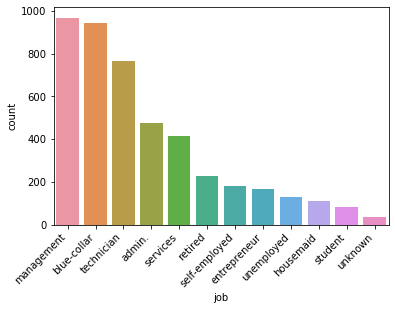

In [5]:
sns.countplot(x='job', data=bank, order=bank['job'].value_counts().index)
plt.xticks(rotation=45, ha='right')

### Transformando categórico em numeral

In [6]:
bank['y'] = bank['y'].map({'no':0,'yes':1})

### Contando número e taxa de aceitações por profissão

In [7]:
unique_jobs = bank['job'].unique()
acceptance_per_job = [bank[bank['job'] == job]['y'].sum() for job in unique_jobs]
acceptance_rate_per_job = [acceptance_per_job[index]/(len(bank[bank['job'] == job])) for index, job in enumerate(unique_jobs)]
data = [item for item in zip(unique_jobs,acceptance_per_job,acceptance_rate_per_job)]
question_1 = pd.DataFrame(columns=['job','acceptances','acceptance_rate'], data=data)

### Número absoluto de aceitações de empréstimo por profissão

Text(0.5, 1.0, 'Número absoluto de aceitações de empréstimo por profissão')

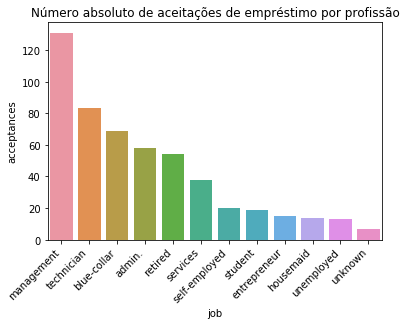

In [8]:
question_1.sort_values(by='acceptances',ascending=False, inplace=True)
ax = sns.barplot(x='job',y='acceptances', data=question_1 )
plt.xticks(rotation=45, ha='right')
ax.set_title('Número absoluto de aceitações de empréstimo por profissão')

### Número proporcional de aceitações de empréstimo por profissão

Text(0.5, 1.0, 'Número proporcional de aceitações de empréstimo por profissão')

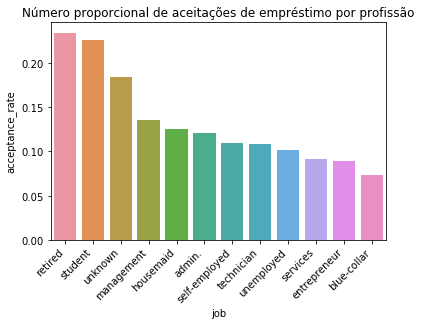

In [9]:
question_1.sort_values(by='acceptance_rate',ascending=False, inplace=True)
ax = sns.barplot(x='job',y='acceptance_rate', data=question_1 )
plt.xticks(rotation=45, ha='right')
ax.set_title('Número proporcional de aceitações de empréstimo por profissão')

### Resposta 1:
#### O número absoluto de pessoas com a profissão relacionada à gerencia que aceitam empréstimo é maior. Porém, proporcionalmente os aposentados aceitam mais empréstimos.
#### Sendo assim, a resposta é: Os aposentados tem maior probabilidade de fazerem um empréstimo.

## Questão 2 - Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

### Quantidade de ligações totais (empréstimos aceitos e não aceitos)

Text(0.5, 1.0, 'Quantidade de ligações totais')

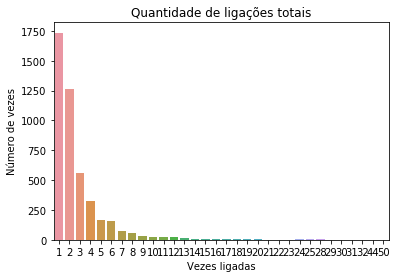

In [10]:
ax = sns.countplot(x='campaign', data=bank)
ax.set(xlabel='Vezes ligadas', ylabel='Número de vezes')
ax.set_title('Quantidade de ligações totais')

### Removendo outliers. Deixando somente valores que estão dentro da distância D em relação à média do número de ligações.
### D = Quartil 1 - Quartil 3

In [11]:
dist = bank['campaign'].values
dist.sort()
d = np.percentile(dist, 75) - np.percentile(dist, 25)
mean = np.mean(dist)
lower_border = math.ceil(mean - d) # 1
upper_border = math.ceil(mean + d) # 5
bank_without_outliers = bank[bank['campaign'] <= upper_border]
bank_without_outliers = bank_without_outliers[bank_without_outliers['campaign'] >= lower_border]

Text(0.5, 1.0, 'Quantidade de ligações totais sem outliers')

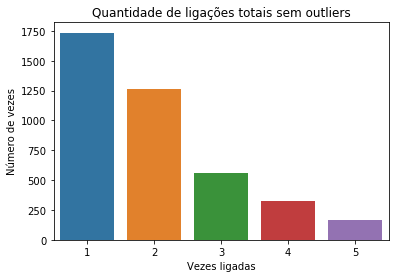

In [12]:
ax = sns.countplot(x='campaign', data=bank_without_outliers)
ax.set(xlabel='Vezes ligadas', ylabel='Número de vezes')
ax.set_title('Quantidade de ligações totais sem outliers')

### Criando taxa de aceitação e contando aceitação das ligações

In [13]:
unique_campaign = bank_without_outliers['campaign'].unique()
campaign_per_call = [bank[bank['campaign'] == campaign]['y'].sum() for campaign in unique_campaign]
campaign_per_call_rate = [(bank[bank['campaign'] == campaign]['y'].sum()/(len(bank[bank['campaign'] == campaign]))) for campaign in unique_campaign]
campaign_per_call_rate_total = [bank[bank['campaign'] == campaign]['y'].sum()/(len(bank)) for campaign in unique_campaign]
n_calls = [len(bank[bank['campaign'] == campaign]) for campaign in unique_campaign]
data = [item for item in zip(unique_campaign,campaign_per_call,campaign_per_call_rate,n_calls, campaign_per_call_rate_total)]
question_2 = pd.DataFrame(columns=['campaign','count_y','rate','n_calls', 'campaign_per_call_rate_total'], data=data)
question_2['negative_rate'] = 1 - question_2['rate']

In [14]:
question_2

,campaign,count_y,rate,n_calls,campaign_per_call_rate_total,negative_rate
0,1,202,0.116494,1734,0.044680,0.883506
1,2,146,0.115506,1264,0.032294,0.884494
2,3,58,0.103943,558,0.012829,0.896057
3,4,36,0.110769,325,0.007963,0.889231
4,5,20,0.119760,167,0.004424,0.880240


### Comparação da quantidade de vezes ligadas com o número de sucessos absoluto

Text(0.5, 1.0, 'Comparação da quantidade de vezes ligadas com o número de sucessos absoluto')

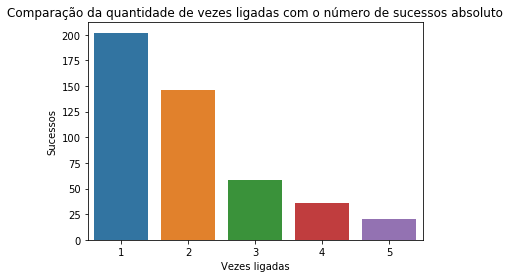

In [15]:
question_2 = question_2.sort_values(['count_y']).reset_index(drop=True)
ax =sns.barplot(x='campaign', y='count_y', data=question_2)
ax.set(xlabel='Vezes ligadas', ylabel='Sucessos')
ax.set_title('Comparação da quantidade de vezes ligadas com o número de sucessos absoluto')

### Comparação da quantidade de vezes ligadas com a taxa de sucesso

Text(0.5, 1.0, 'Comparação da quantidade de vezes ligadas com a taxa de sucesso')

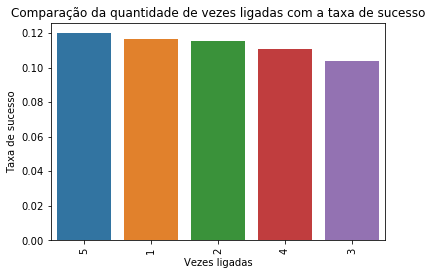

In [16]:
question_2 = question_2.sort_values(['rate'], ascending=False).reset_index(drop=True)
ax = sns.barplot(x='campaign', y='rate', data=question_2, order=question_2['campaign'])
ax.set(xlabel='Vezes ligadas', ylabel='Taxa de sucesso')
plt.xticks(rotation=90, ha='center')
ax.set_title('Comparação da quantidade de vezes ligadas com a taxa de sucesso')

### Comparação da quantidade de vezes ligadas com a taxa de sucesso entre todas ligações

Text(0.5, 1.0, 'Comparação da quantidade de vezes ligadas com a taxa de sucesso entre todas ligações')

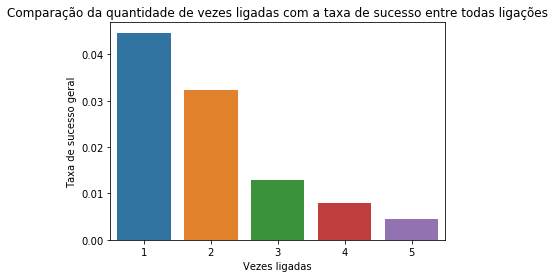

In [17]:
question_2 = question_2.sort_values(['rate']).reset_index(drop=True)
ax = sns.barplot(x='campaign', y='campaign_per_call_rate_total', data=question_2)
ax.set(xlabel='Vezes ligadas', ylabel='Taxa de sucesso geral')
ax.set_title('Comparação da quantidade de vezes ligadas com a taxa de sucesso entre todas ligações')

### Calculando a probabilidade combinada de aceitarem o empréstimo entre a primeira e a quinta ligação

In [18]:
def combinated_rate(df, x, value=1, count=1):
    if count == x:
        return  value*df[df['campaign'] == x]['rate'].values
    value = df[df['campaign'] == count]['negative_rate'].values*value
    return combinated_rate(df, x, value, count+1)

In [19]:
question_2 = question_2.sort_values(['campaign']).reset_index(drop=True)
question_2['combinatory_success'] = [combinated_rate(question_2,index+1)[0] for index,_ in enumerate(question_2['campaign'])]

Text(0.5, 1.0, 'Probabilidade combinada')

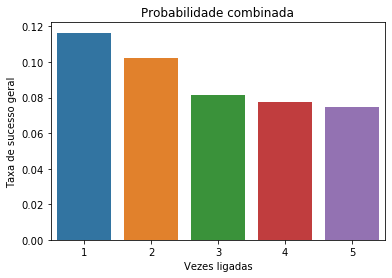

In [20]:
ax = sns.barplot(x='campaign', y='combinatory_success', data=question_2)
ax.set(xlabel='Vezes ligadas', ylabel='Taxa de sucesso geral')
ax.set_title('Probabilidade combinada')

In [21]:
question_2

,campaign,count_y,rate,n_calls,campaign_per_call_rate_total,negative_rate,combinatory_success
0,1,202,0.116494,1734,0.044680,0.883506,0.116494
1,2,146,0.115506,1264,0.032294,0.884494,0.102051
2,3,58,0.103943,558,0.012829,0.896057,0.081227
3,4,36,0.110769,325,0.007963,0.889231,0.077564
4,5,20,0.119760,167,0.004424,0.880240,0.074571


## Resposta 2:
#### A taxa de aceitação da a primeira até a quinta ligação é: 11%, 11%, 10%, 11%, 10%
#### Apesar da taxa de aceitação permanecer relativamente a mesma, a probabilidade combinada de aceitação diminui conforme o número de ligações aumenta.
#### A propabilidade de aceitação da primeira até a quinta ligação é: 11%, 10%, 8%, 7%, 7%


## Resposta 3:
#### Número médio de 2 ligações, pois a partir da quinta ligação a probabilidade de aceitação é muito baixa.

## Questão 4 - O resultado da campanha anterior tem relevância na campanha atual?

### Análisando o número de tentativas anteriores

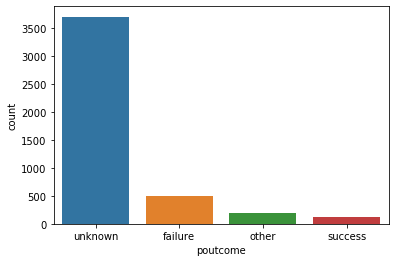

In [22]:
sns.countplot(x=bank['poutcome'], data=bank)

### Preparando dados para o gráfico

In [23]:
question_4 = bank.copy()
question_4['sucess_rate'] = 0
question_4['fail_rate'] = 0
for poutcome in question_4['poutcome'].unique():
    df = question_4[question_4['poutcome'] == poutcome]
    question_4.loc[question_4['poutcome']==poutcome,'sucess_rate'] = len(df[df['y'] ==1])/len(df)
    question_4.loc[question_4['poutcome']==poutcome,'fail_rate'] = len(df[df['y'] ==0])/len(df)
columns = ['poutcome', 'rate','type_rate']
plot_df = pd.DataFrame(columns=columns)
for poutcome in question_4['poutcome'].unique():
    row = question_4[question_4['poutcome'] == poutcome].iloc[0]
    plot_df = plot_df.append(pd.DataFrame(columns=columns, data={'poutcome':[poutcome],'rate':[row['sucess_rate']],'type_rate':['success']}))
    plot_df = plot_df.append(pd.DataFrame(columns=columns, data={'poutcome':[poutcome],'rate':[row['fail_rate']],'type_rate':['fail']}))
    

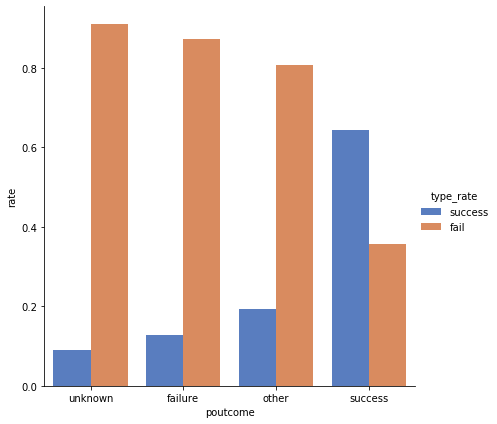

In [24]:
sns.catplot(x="poutcome", y="rate", hue="type_rate", data=plot_df,
                height=6, kind="bar", palette="muted")

#### Se há diferença significativa da taxa de sucesso entre um dos 4 poutcomes, significa que a campanha anterior tem relevância.
#### Hipótese 0 : A diferença entre as taxas é zero
#### Hipótese 1 : A diferença entre as taxas NÃO é zero
#### Como se trata de uma distribuição bimodal será utilizado o t_test

In [25]:
p_values= {}
for poutcome_1 in question_4['poutcome'].unique():
    for poutcome_2 in question_4['poutcome'].unique():
        if poutcome_1 != poutcome_2:
            _,p_value,_ = sm.stats.ttest_ind(question_4[question_4['poutcome'] == poutcome_1]['y'].values, question_4[question_4['poutcome'] == poutcome_2]['y'].values)
            p_values[poutcome_1+'_'+poutcome_2] = p_value

In [26]:
p_values

{'unknown_failure': 0.00771001494449203,
 'unknown_other': 2.1856396835955615e-06,
 'unknown_success': 2.1465047986452904e-91,
 'failure_unknown': 0.00771001494449203,
 'failure_other': 0.03133482818879955,
 'failure_success': 3.8143967061934695e-39,
 'other_unknown': 2.1856396835955615e-06,
 'other_failure': 0.03133482818879955,
 'other_success': 3.812024893967666e-18,
 'success_unknown': 2.1465047986452904e-91,
 'success_failure': 3.8143967061934695e-39,
 'success_other': 3.812024893967666e-18}

In [27]:
max(p_values.values())

0.03133482818879955

## Resposta 4:
#### Como o p-value máximo é menor que 0.4, a hipótese nula tem que ser rejeitada. Sendo assim, A diferença entre as taxa É significante.
#### O resultado da campanha anterior é relevante para campanha atual.

## 5 - Qual o fator determinante para que o banco exija um seguro de crédito?

#### Não entendi essa pergunta. Só a variável 'default' tem a palavra credit na descrição.
#### A descrição das variáveis é:
Attribute Information:

Input variables:

bank client data:

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')


## 6 - Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

#### Fazer um modelo interpretável e verificar o que leva uma pessoa a ter um empréstimo imobiliário


#### Análise de proporção de classes

In [28]:
question_6 = bank.copy()

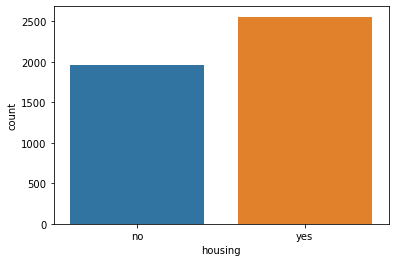

In [29]:
sns.countplot(x='housing', data=question_6)

#### Removendo colunas que não serão usadas no modelo

In [30]:
question_6 = question_6.iloc[:,:-9]

#### Reordenando colunas

In [31]:
question_6['housing'] = question_6['housing'].map({'no':0,'yes':1})
columns = question_6.columns.tolist()
columns = [columns[-3]] + columns[:-3] + [columns[-1]] + [columns[-2]]
question_6 = question_6[columns]
question_6_y = question_6['housing']
question_6_y
question_6.drop(columns=['housing'], axis=1, inplace=True)

#### Normalizando valores numéricos

In [32]:
question_6_bal_age = question_6.loc[:,['balance','age']].values
bins = MinMaxScaler()
bins.fit(question_6_bal_age)
question_6_bal_age = bins.transform(question_6_bal_age)
question_6['balance'] = question_6_bal_age[:,0]
question_6['age'] = question_6_bal_age[:,1]

#### One_hot encoding

In [33]:
enc = OneHotEncoder()
enc.fit(question_6.iloc[:,2:].values)
encoded = enc.transform(question_6.iloc[:,2:].values).toarray()
enc.get_feature_names()

array(['x0_admin.', 'x0_blue-collar', 'x0_entrepreneur', 'x0_housemaid',
       'x0_management', 'x0_retired', 'x0_self-employed', 'x0_services',
       'x0_student', 'x0_technician', 'x0_unemployed', 'x0_unknown',
       'x1_divorced', 'x1_married', 'x1_single', 'x2_primary',
       'x2_secondary', 'x2_tertiary', 'x2_unknown', 'x3_no', 'x3_yes',
       'x4_no', 'x4_yes'], dtype=object)

#### Juntando valores continuos escalados e valores categoricos one-hot-encoded

In [34]:
encoded = np.column_stack((question_6.iloc[:,:2].values, encoded))

#### Separando amostra para Teste

In [35]:
X_root = encoded[:,:-1]
y_root = question_6_y.values
X, X_validation, y, y_validation = train_test_split(X_root, y_root, test_size=0.1, random_state=42)

#### Treinando modelo com KFold, foi utilizado um modelo de Regressão Logistica como BaseLine

In [36]:
n_splits=5
kf = KFold(n_splits=n_splits)
score_list = []
precision_list = []
confusion_mean = []
precisions_mean = []
scores_mean = []
models=[tree.DecisionTreeClassifier(criterion='entropy', max_depth=4), LogisticRegression()]
for model in models:
    confusion_sum = [[0,0],[0,0]]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = model.fit(X_train, y_train)
        predict = model.predict(X_test)
        
        score_list.append(f1_score(y_test,predict))
        precision_list.append(precision_score(y_test,predict))
        confusion_sum = confusion_sum + confusion_matrix(y_test,predict)

    precisions_mean.append(np.mean(precision_list))
    scores_mean.append(np.mean(score_list))
    confusion_mean.append(np.array(confusion_sum/n_splits))
    
print('Precision mean: ',precisions_mean)
print('F1 score mean: ',scores_mean)
print('Confusion matrix mean: ', confusion_mean)

Precision mean:  [0.5996426387153522, 0.6198443288375477]
F1 score mean:  [0.7158569690209179, 0.7077538466566969]
Confusion matrix mean:  [array([[ 89.2, 270.4],
       [ 50.2, 403.8]]), array([[162. , 197.6],
       [103.4, 350.6]])]


#### Testando o modelo na amostra de teste

In [37]:
for model in models:
    predict = model.predict(X_validation)
    precision = precision_score(y_validation,predict)
    score = f1_score(y_validation,predict)
    confusion_matrix_result = confusion_matrix(y_validation,predict)
    print('Precision on validation: ',precision)
    print('F1 score on validation: ', score)
    print('Confusion matrix: ', confusion_matrix_result)

Precision on validation:  0.6925133689839572
F1 score on validation:  0.7812971342383107
Confusion matrix:  [[ 49 115]
 [ 30 259]]
Precision on validation:  0.6996904024767802
F1 score on validation:  0.7385620915032679
Confusion matrix:  [[ 67  97]
 [ 63 226]]


#### Modelos obtiveram scores próximo, treinando árvore final

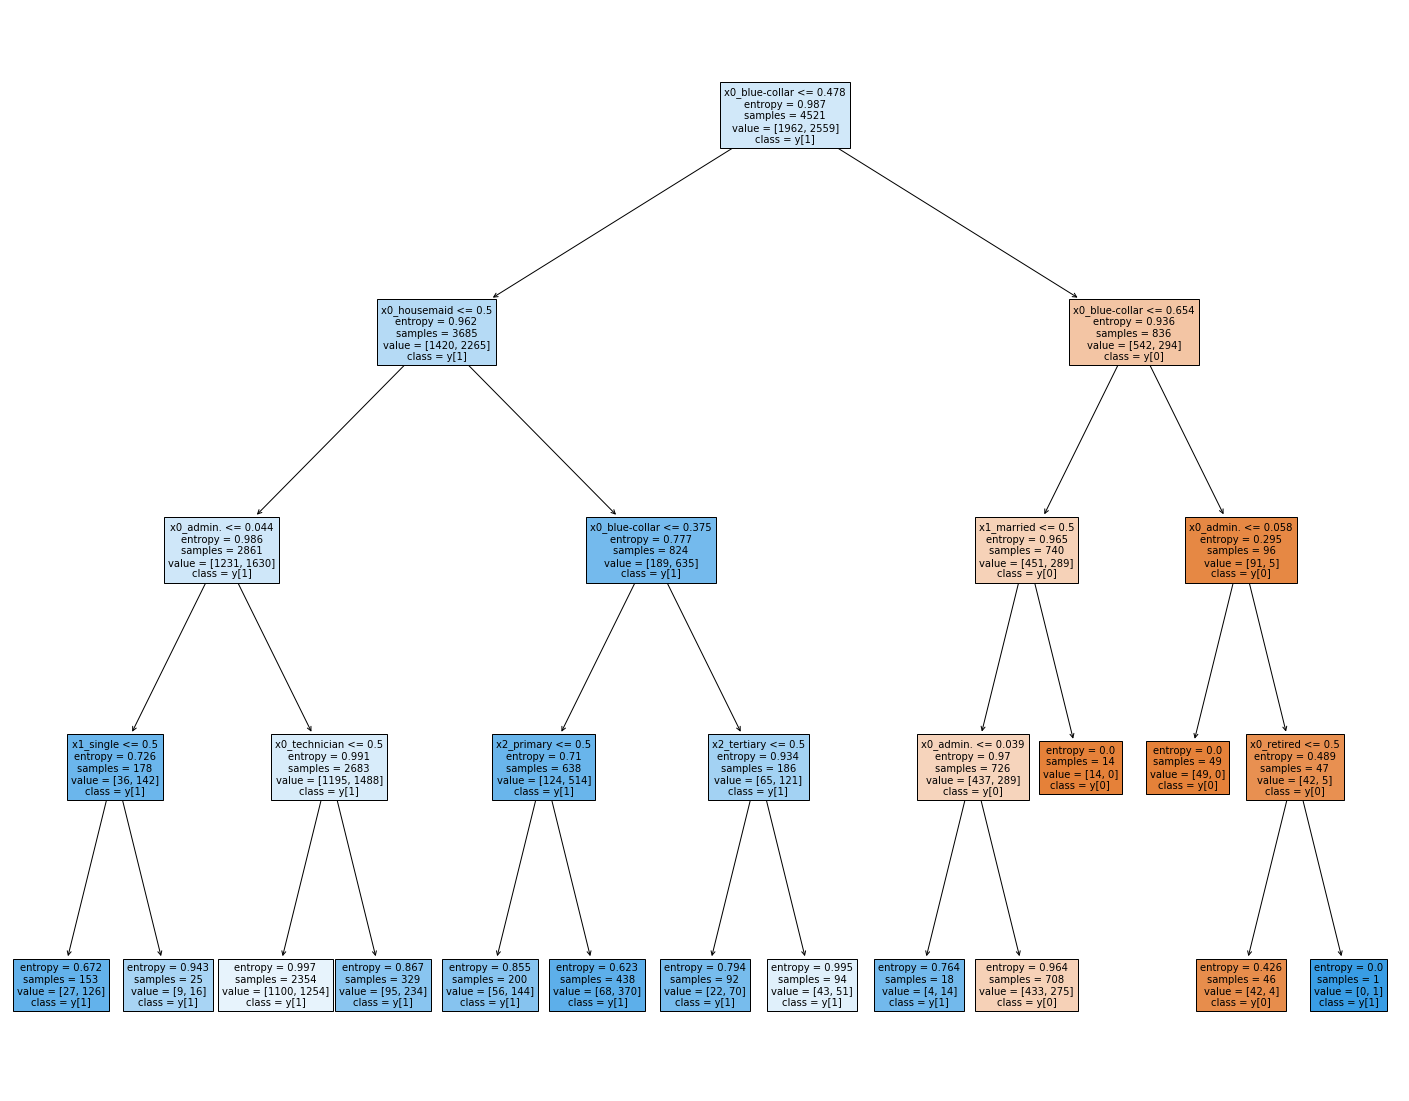

In [38]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf = clf.fit(X_root, y_root)
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot()
ax = tree.plot_tree(clf,feature_names=enc.get_feature_names(), class_names=True, ax=ax,fontsize=10, max_depth=4, filled=True)
plt.savefig('tree.png')

## Resposta 6:
#### Os fatores mais proeminentes são os caminhos com nós e folhas em azul mais escuro pois a proporção de pessoas com empréstimo imobiliário neles é maior.
#### Sendo assim os fatores mais predominantes em ordem de importancia são: 
#### 1. Não ter como profissão blue-collar;
#### 2. não ter como profissão housemaid;
#### 3. e ter completado o ensino primário.